In [1]:
# Mount Google Drive and install dependencies
# Install required packages
!pip install -q pydicom scikit-image seaborn transformers

# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# Image processing
from skimage import filters, morphology, measure, exposure
from skimage.transform import resize
from skimage.filters import gaussian
from scipy import ndimage

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Google Drive mounted and libraries imported successfully!")
print(f"✓ TensorFlow version: {tf.__version__}")


2025-06-27 15:16:46.107811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751037406.278072      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751037406.328640      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ Google Drive mounted and libraries imported successfully!
✓ TensorFlow version: 2.18.0


In [2]:
# Configure data paths based on search results recommendations
BASE_PATH = '/kaggle/input/liver-data/work'  # Adjust to your path
CT_IMAGES_PATH = os.path.join(BASE_PATH, 'ct_images')
LIVER_MASKS_PATH = os.path.join(BASE_PATH, 'liver_mask2')
TUMOR_MASKS_PATH = os.path.join(BASE_PATH, 'tumor_masks2')

# Verify paths
print("Checking data paths...")
for path_name, path in [("CT Images", CT_IMAGES_PATH), 
                       ("Liver Masks", LIVER_MASKS_PATH), 
                       ("Tumor Masks", TUMOR_MASKS_PATH)]:
    if os.path.exists(path):
        file_count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        print(f"✓ {path_name}: {file_count} files found")
    else:
        print(f"✗ {path_name}: Path not found - {path}")

# Configuration parameters
IMG_SIZE = 256
PATCH_SIZE = 16
NUM_CLASSES_SEG = 3  # Background, Liver, Tumor
NUM_CLASSES_CLS = 2  # No Tumor, Tumor Present
BATCH_SIZE = 8
MAX_SAMPLES = 1000  # Adjust based on your memory


Checking data paths...
✓ CT Images: 505 files found
✓ Liver Masks: 500 files found
✓ Tumor Masks: 500 files found


In [3]:
def get_image_files(directory, extensions=['.png', '.jpg', '.jpeg', '.dcm', '.tif', '.tiff']):
    """
    Get all image files from a directory with specified extensions
    """
    image_files = []
    if os.path.exists(directory):
        for ext in extensions:
            pattern = os.path.join(directory, f'*{ext}')
            image_files.extend(glob.glob(pattern))
            pattern = os.path.join(directory, f'*{ext.upper()}')
            image_files.extend(glob.glob(pattern))
    return sorted(image_files)

def load_image(image_path):
    """
    Load image from various formats (PNG, JPG, DICOM, etc.)
    """
    try:
        if image_path.lower().endswith('.dcm'):
            # Load DICOM file
            import pydicom
            dicom_data = pydicom.dcmread(image_path)
            image = dicom_data.pixel_array.astype(np.float32)
        else:
            # Load regular image formats
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                # Try with PIL as backup
                from PIL import Image
                image = np.array(Image.open(image_path).convert('L')).astype(np.float32)
            else:
                image = image.astype(np.float32)
        
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def match_files_by_name(ct_files, mask_files):
    """
    Match CT images with corresponding mask files based on filename
    Improved matching logic to avoid incorrect substring matches
    """
    matched_pairs = []
    
    # Create a dictionary for faster lookup
    mask_dict = {}
    for mask_file in mask_files:
        mask_basename = os.path.splitext(os.path.basename(mask_file))[0]
        mask_dict[mask_basename] = mask_file
    
    for ct_file in ct_files:
        ct_basename = os.path.splitext(os.path.basename(ct_file))[0]
        
        mask_file = None
        
        # Strategy 1: Exact match (highest priority)
        if ct_basename in mask_dict:
            mask_file = mask_dict[ct_basename]
        else:
            # Strategy 2: Try to find the best match
            best_match = None
            best_score = -1
            
            for mask_basename, mask_f in mask_dict.items():
                # Calculate similarity score
                score = 0
                
                # Exact match gets highest score
                if ct_basename == mask_basename:
                    score = 1000
                # Check if one is contained in the other, but be more careful
                elif len(ct_basename) > 0 and len(mask_basename) > 0:
                    # Only consider substring matches if they make sense
                    if (ct_basename in mask_basename and 
                        len(ct_basename) >= len(mask_basename) * 0.5):
                        score = 500 + len(ct_basename)
                    elif (mask_basename in ct_basename and 
                          len(mask_basename) >= len(ct_basename) * 0.5):
                        score = 500 + len(mask_basename)
                    # Check for numeric similarity (for numbered files)
                    elif ct_basename.isdigit() and mask_basename.isdigit():
                        ct_num = int(ct_basename)
                        mask_num = int(mask_basename)
                        if ct_num == mask_num:
                            score = 1000
                
                if score > best_score:
                    best_score = score
                    best_match = mask_f
            
            # Only accept the match if it's a good one
            if best_score >= 1000:  # Only exact matches or very high confidence
                mask_file = best_match
        
        # Add the pair (with None if no good match found)
        matched_pairs.append((ct_file, mask_file))
    
    return matched_pairs

# Alternative: Even more robust matching function
def match_files_by_name_robust(ct_files, mask_files):
    """
    More robust matching that handles numbered files correctly
    """
    matched_pairs = []
    
    # Create dictionaries for different matching strategies
    mask_dict_exact = {}
    mask_dict_numeric = {}
    
    for mask_file in mask_files:
        mask_basename = os.path.splitext(os.path.basename(mask_file))[0]
        
        # Store exact matches
        mask_dict_exact[mask_basename] = mask_file
        
        # Store numeric matches if the basename is a number
        if mask_basename.isdigit():
            mask_dict_numeric[int(mask_basename)] = mask_file
    
    unmatched_ct = []
    
    for ct_file in ct_files:
        ct_basename = os.path.splitext(os.path.basename(ct_file))[0]
        mask_file = None
        
        # Strategy 1: Exact string match
        if ct_basename in mask_dict_exact:
            mask_file = mask_dict_exact[ct_basename]
        
        # Strategy 2: Numeric match (for numbered files)
        elif ct_basename.isdigit():
            ct_num = int(ct_basename)
            if ct_num in mask_dict_numeric:
                mask_file = mask_dict_numeric[ct_num]
        
        # Strategy 3: Try to find partial matches (be very careful)
        if mask_file is None:
            # Only do this for non-numeric filenames to avoid the "0" in "10" issue
            if not ct_basename.isdigit():
                for mask_basename, mask_f in mask_dict_exact.items():
                    # Only match if the shorter string is at least 50% of the longer string
                    min_len = min(len(ct_basename), len(mask_basename))
                    max_len = max(len(ct_basename), len(mask_basename))
                    
                    if (min_len >= max_len * 0.5 and 
                        (ct_basename in mask_basename or mask_basename in ct_basename)):
                        mask_file = mask_f
                        break
        
        if mask_file is None:
            unmatched_ct.append(ct_file)
        
        matched_pairs.append((ct_file, mask_file))
    
    return matched_pairs

# Get all image files
ct_files = get_image_files(CT_IMAGES_PATH)
liver_mask_files = get_image_files(LIVER_MASKS_PATH)
tumor_mask_files = get_image_files(TUMOR_MASKS_PATH)

print(f"Found {len(ct_files)} CT images")
print(f"Found {len(liver_mask_files)} liver masks")
print(f"Found {len(tumor_mask_files)} tumor masks")

# Use the robust matching function
print("\nUsing robust matching algorithm...")
ct_liver_pairs = match_files_by_name_robust(ct_files, liver_mask_files)
ct_tumor_pairs = match_files_by_name_robust(ct_files, tumor_mask_files)

print(f"\nMatched {len([p for p in ct_liver_pairs if p[1] is not None])} CT-liver pairs")
print(f"Matched {len([p for p in ct_tumor_pairs if p[1] is not None])} CT-tumor pairs")

# Display sample file pairs
print(f"\nSample matched pairs:")
for i, (ct_file, liver_file) in enumerate(ct_liver_pairs[:5]):
    print(f"Pair {i+1}:")
    print(f"  CT: {os.path.basename(ct_file)}")
    print(f"  Liver: {os.path.basename(liver_file) if liver_file else 'None'}")

# Check for any mismatches
print(f"\nChecking for potential mismatches...")
mismatch_count = 0
for i, (ct_file, liver_file) in enumerate(ct_liver_pairs):
    if liver_file is not None:
        ct_basename = os.path.splitext(os.path.basename(ct_file))[0]
        liver_basename = os.path.splitext(os.path.basename(liver_file))[0]
        
        # Check if they should match exactly
        if ct_basename.isdigit() and liver_basename.isdigit():
            if int(ct_basename) != int(liver_basename):
                print(f"  Potential mismatch: CT {ct_basename} -> Liver {liver_basename}")
                mismatch_count += 1
        elif ct_basename != liver_basename:
            print(f"  Potential mismatch: CT {ct_basename} -> Liver {liver_basename}")
            mismatch_count += 1

if mismatch_count == 0:
    print("  ✓ No mismatches detected!")
else:
    print(f"  ⚠️  Found {mismatch_count} potential mismatches")

# List unmatched files
unmatched_ct = [ct for ct, liver in ct_liver_pairs if liver is None]
if unmatched_ct:
    print(f"\nUnmatched CT files ({len(unmatched_ct)}):")
    for ct_file in unmatched_ct[:5]:  # Show first 5
        print(f"  {os.path.basename(ct_file)}")
    if len(unmatched_ct) > 5:
        print(f"  ... and {len(unmatched_ct) - 5} more")


Found 505 CT images
Found 500 liver masks
Found 500 tumor masks

Using robust matching algorithm...

Matched 500 CT-liver pairs
Matched 500 CT-tumor pairs

Sample matched pairs:
Pair 1:
  CT: 0.jpg
  Liver: 0.jpg
Pair 2:
  CT: 1.jpg
  Liver: 1.jpg
Pair 3:
  CT: 10.jpg
  Liver: 10.jpg
Pair 4:
  CT: 100.jpg
  Liver: 100.jpg
Pair 5:
  CT: 101.jpg
  Liver: 101.jpg

Checking for potential mismatches...
  ✓ No mismatches detected!

Unmatched CT files (5):
  357.jpg
  358.jpg
  359.jpg
  360.jpg
  361.jpg


In [4]:
def hounsfield_filtering(ct_image):
    """
    Apply Hounsfield Unit filtering to focus on liver tissue
    Based on medical imaging research
    """
    slope = 0.00390625
    min_val = np.min(ct_image)

    if min_val <= 0:
        intercept = 0.1 * min_val
    else:
        intercept = -min_val

    # Apply Hounsfield transformation
    filtered_image = slope * ct_image + intercept
    return filtered_image

def gaussian_noise_removal(image, sigma=1.0):
    """
    Apply Gaussian filter to remove noise from CT images
    """
    return gaussian(image, sigma=sigma, preserve_range=True)

def normalize_image(image):
    """
    Normalize image to [0, 1] range for deep learning model input
    """
    image = image.astype(np.float32)
    image_min, image_max = np.min(image), np.max(image)

    if image_max > image_min:
        normalized = (image - image_min) / (image_max - image_min)
    else:
        normalized = np.zeros_like(image)

    return normalized

def preprocess_ct_slice(ct_slice, target_size=(256, 256)):
    """
    Complete preprocessing pipeline for a CT slice
    """
    if ct_slice is None:
        return np.zeros(target_size, dtype=np.float32)

    # Apply Hounsfield filtering
    hounsfield_filtered = hounsfield_filtering(ct_slice)

    # Remove noise with Gaussian filter
    denoised = gaussian_noise_removal(hounsfield_filtered, sigma=1.0)

    # Normalize to [0, 1]
    normalized = normalize_image(denoised)

    # Resize to target size for consistent input
    if normalized.shape != target_size:
        resized = resize(normalized, target_size, preserve_range=True, anti_aliasing=True)
    else:
        resized = normalized

    return resized.astype(np.float32)

def preprocess_mask(mask, target_size=(256, 256)):
    """
    Preprocess segmentation masks
    """
    if mask is None:
        return np.zeros(target_size, dtype=np.float32)

    # Ensure binary mask (for masks that might have different value ranges)
    if np.max(mask) > 1:
        binary_mask = (mask > np.max(mask) * 0.5).astype(np.float32)
    else:
        binary_mask = (mask > 0.5).astype(np.float32)

    # Resize to target size
    if binary_mask.shape != target_size:
        resized_mask = resize(binary_mask, target_size, preserve_range=True, anti_aliasing=False)
        resized_mask = (resized_mask > 0.5).astype(np.float32)
    else:
        resized_mask = binary_mask

    return resized_mask

print("✓ Preprocessing functions defined successfully!")

# Test preprocessing on a sample image if available
if ct_files:
    sample_ct = load_image(ct_files[0])
    if sample_ct is not None:
        processed_sample = preprocess_ct_slice(sample_ct)
        print(f"✓ Sample preprocessing test:")
        print(f"  Original shape: {sample_ct.shape}, range: [{sample_ct.min():.1f}, {sample_ct.max():.1f}]")
        print(f"  Processed shape: {processed_sample.shape}, range: [{processed_sample.min():.3f}, {processed_sample.max():.3f}]")


✓ Preprocessing functions defined successfully!
✓ Sample preprocessing test:
  Original shape: (512, 512), range: [0.0, 255.0]
  Processed shape: (256, 256), range: [0.000, 0.999]


In [5]:
def load_complete_dataset(ct_files, liver_mask_files, tumor_mask_files, max_samples=None):
    """
    Load complete dataset with CT images and corresponding masks
    """
    # Match all files
    ct_liver_pairs = match_files_by_name(ct_files, liver_mask_files)
    ct_tumor_pairs = match_files_by_name(ct_files, tumor_mask_files)

    # Create mapping for tumor masks
    tumor_dict = {os.path.basename(ct): tumor for ct, tumor in ct_tumor_pairs}

    ct_images = []
    liver_masks = []
    tumor_masks = []
    labels = []  # For classification: 0 = no tumor, 1 = tumor present

    print("Loading dataset...")

    # Limit samples if specified
    pairs_to_process = ct_liver_pairs[:max_samples] if max_samples else ct_liver_pairs

    for i, (ct_file, liver_file) in enumerate(pairs_to_process):
        if i % 50 == 0:
            print(f"Processing {i+1}/{len(pairs_to_process)} images...")

        # Load CT image
        ct_image = load_image(ct_file)
        if ct_image is None:
            continue

        # Load liver mask
        liver_mask = None
        if liver_file and os.path.exists(liver_file):
            liver_mask = load_image(liver_file)

        # Find corresponding tumor mask
        ct_basename = os.path.basename(ct_file)
        tumor_file = tumor_dict.get(ct_basename)
        tumor_mask = None
        if tumor_file and os.path.exists(tumor_file):
            tumor_mask = load_image(tumor_file)

        # Preprocess images
        processed_ct = preprocess_ct_slice(ct_image)
        processed_liver = preprocess_mask(liver_mask)
        processed_tumor = preprocess_mask(tumor_mask)

        # Determine if tumor is present
        has_tumor = 1 if (processed_tumor.sum() > 0) else 0

        # Store processed data
        ct_images.append(processed_ct)
        liver_masks.append(processed_liver)
        tumor_masks.append(processed_tumor)
        labels.append(has_tumor)

    return (np.array(ct_images), np.array(liver_masks),
            np.array(tumor_masks), np.array(labels))

# Load the dataset (limit to reasonable number for Colab memory)
print("Loading dataset from your Google Drive...")
MAX_SAMPLES = 500  # Adjust based on your available memory and dataset size

X_images, y_liver_masks, y_tumor_masks, classification_labels = load_complete_dataset(
    ct_files, liver_mask_files, tumor_mask_files, max_samples=MAX_SAMPLES
)

print(f"✓ Dataset loaded successfully!")
print(f"  Images shape: {X_images.shape}")
print(f"  Liver masks shape: {y_liver_masks.shape}")
print(f"  Tumor masks shape: {y_tumor_masks.shape}")
print(f"  Classification labels shape: {classification_labels.shape}")
print(f"  Tumor prevalence: {np.mean(classification_labels):.2%}")
print(f"  Memory usage: {(X_images.nbytes + y_liver_masks.nbytes + y_tumor_masks.nbytes) / 1024**3:.2f} GB")


Loading dataset from your Google Drive...
Loading dataset...
Processing 1/500 images...
Processing 51/500 images...
Processing 101/500 images...
Processing 151/500 images...
Processing 201/500 images...
Processing 251/500 images...
Processing 301/500 images...
Processing 351/500 images...
Processing 401/500 images...
Processing 451/500 images...
✓ Dataset loaded successfully!
  Images shape: (500, 256, 256)
  Liver masks shape: (500, 256, 256)
  Tumor masks shape: (500, 256, 256)
  Classification labels shape: (500,)
  Tumor prevalence: 44.00%
  Memory usage: 0.37 GB


Sample images from your dataset:


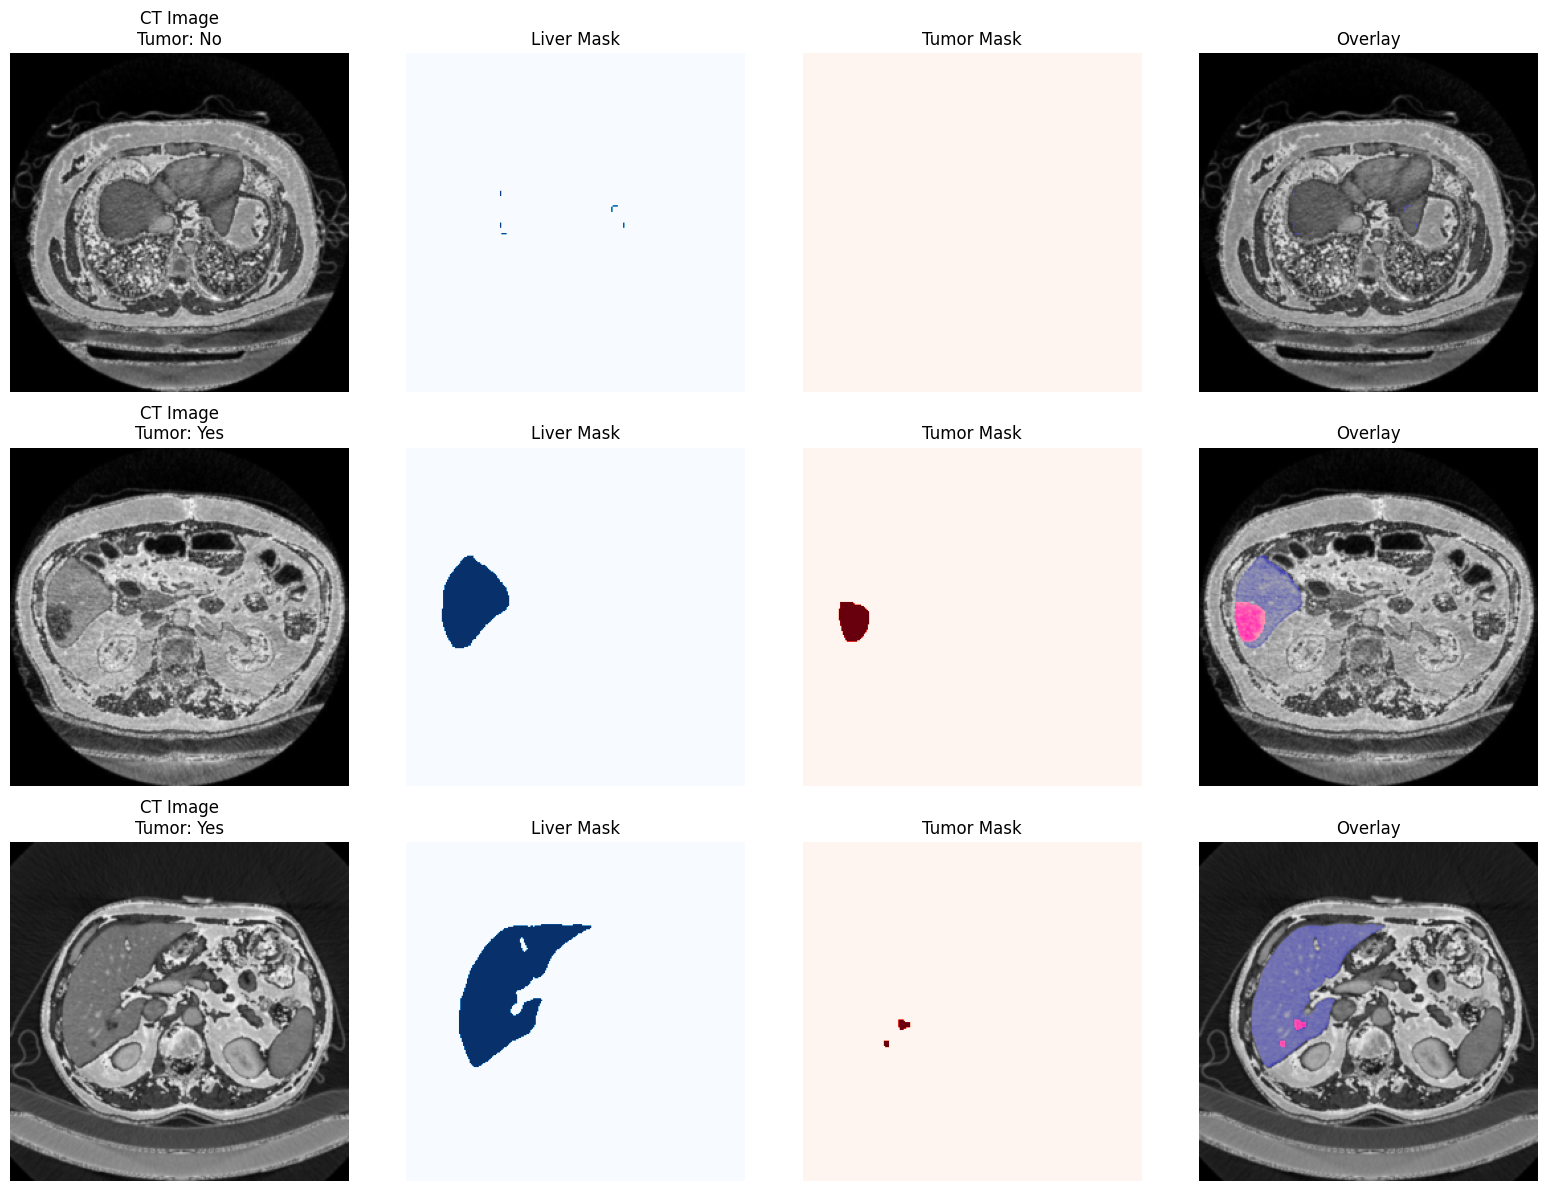

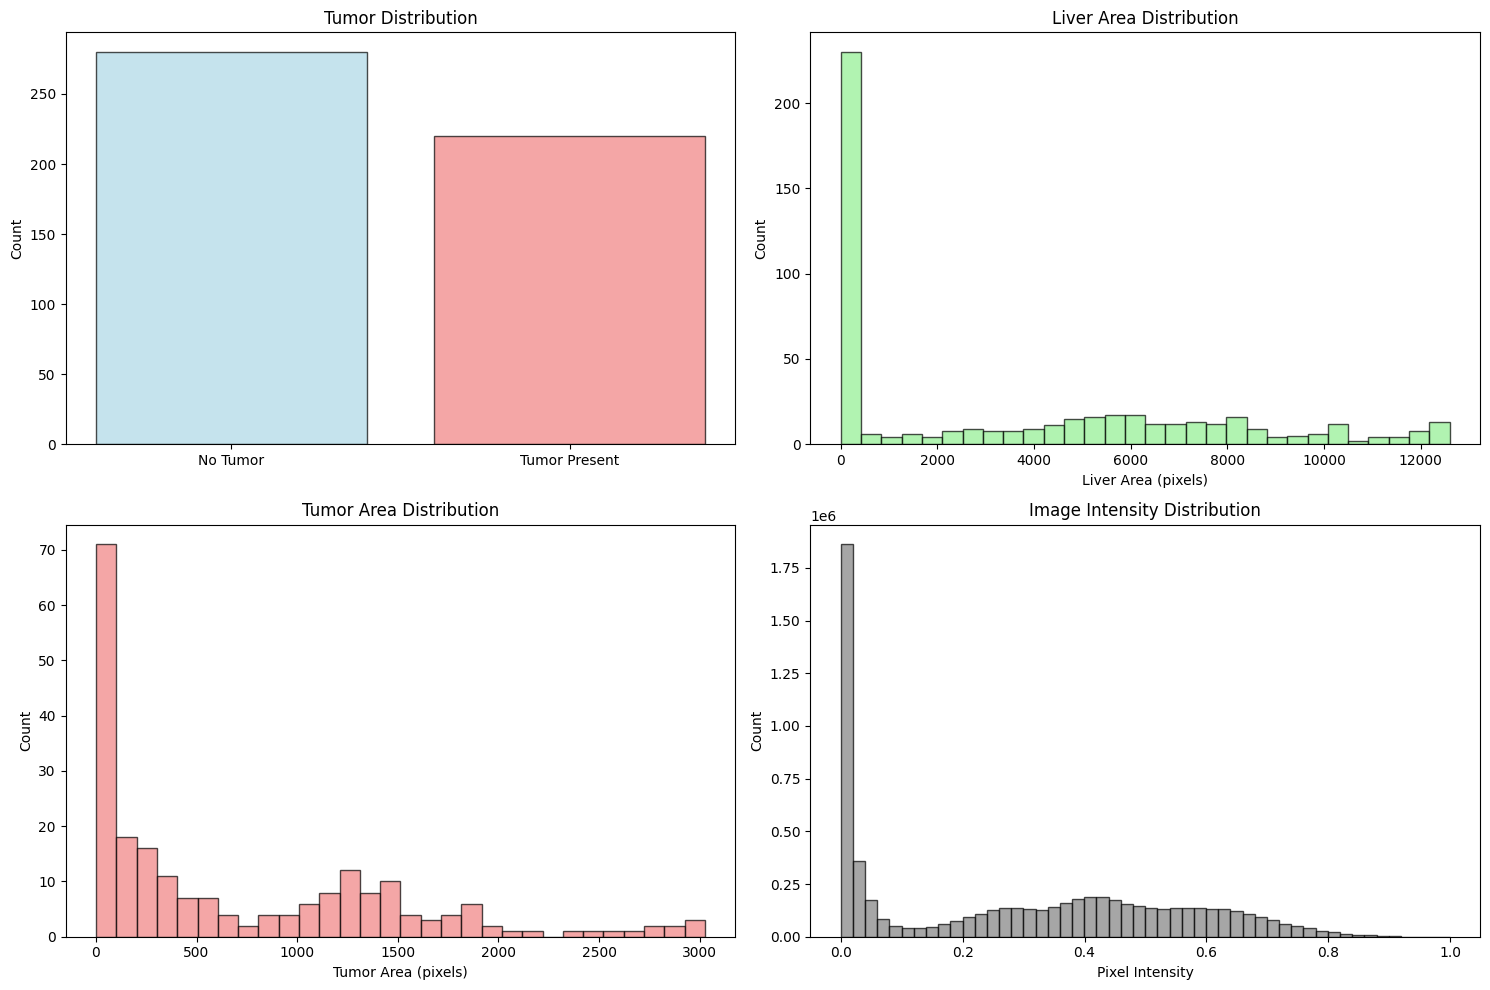

Dataset Statistics:
Total samples: 500
Images with tumors: 220 (44.0%)
Images without tumors: 280 (56.0%)
Average liver area: 3517.8 pixels
Average tumor area (when present): 708.9 pixels
Image dimensions: (256, 256)
Pixel intensity range: [0.000, 1.000]


In [6]:
# Visualize sample data
def visualize_samples(images, liver_masks, tumor_masks, labels, num_samples=4):
    """
    Visualize CT images with corresponding masks
    """
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        idx = np.random.randint(0, len(images))

        # Original CT image
        axes[i, 0].imshow(images[idx], cmap='gray')
        axes[i, 0].set_title(f'CT Image\nTumor: {"Yes" if labels[idx] == 1 else "No"}')
        axes[i, 0].axis('off')

        # Liver mask
        axes[i, 1].imshow(liver_masks[idx], cmap='Blues')
        axes[i, 1].set_title('Liver Mask')
        axes[i, 1].axis('off')

        # Tumor mask
        axes[i, 2].imshow(tumor_masks[idx], cmap='Reds')
        axes[i, 2].set_title('Tumor Mask')
        axes[i, 2].axis('off')

        # Combined overlay
        overlay = images[idx].copy()
        overlay_colored = np.stack([overlay, overlay, overlay], axis=-1)

        # Add liver (blue) and tumor (red) overlays
        liver_overlay = liver_masks[idx] > 0.5
        tumor_overlay = tumor_masks[idx] > 0.5

        overlay_colored[liver_overlay, 2] = np.maximum(overlay_colored[liver_overlay, 2], 0.7)  # Blue for liver
        overlay_colored[tumor_overlay, 0] = np.maximum(overlay_colored[tumor_overlay, 0], 1.0)  # Red for tumor

        axes[i, 3].imshow(overlay_colored)
        axes[i, 3].set_title('Overlay')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample data
print("Sample images from your dataset:")
visualize_samples(X_images, y_liver_masks, y_tumor_masks, classification_labels, num_samples=3)

# Display dataset statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tumor distribution
axes[0, 0].bar(['No Tumor', 'Tumor Present'],
               [np.sum(classification_labels == 0), np.sum(classification_labels == 1)],
               color=['lightblue', 'lightcoral'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Tumor Distribution')
axes[0, 0].set_ylabel('Count')

# Liver area distribution
liver_areas = [np.sum(mask) for mask in y_liver_masks]
axes[0, 1].hist(liver_areas, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Liver Area Distribution')
axes[0, 1].set_xlabel('Liver Area (pixels)')
axes[0, 1].set_ylabel('Count')

# Tumor area distribution (only non-zero areas)
tumor_areas = [np.sum(mask) for mask in y_tumor_masks if np.sum(mask) > 0]
if tumor_areas:
    axes[1, 0].hist(tumor_areas, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 0].set_title('Tumor Area Distribution')
    axes[1, 0].set_xlabel('Tumor Area (pixels)')
    axes[1, 0].set_ylabel('Count')
else:
    axes[1, 0].text(0.5, 0.5, 'No tumors detected\nin dataset',
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Tumor Area Distribution')

# Image intensity distribution
sample_intensities = X_images[:100].flatten()  # Sample from first 100 images
axes[1, 1].hist(sample_intensities, bins=50, alpha=0.7, color='gray', edgecolor='black')
axes[1, 1].set_title('Image Intensity Distribution')
axes[1, 1].set_xlabel('Pixel Intensity')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Dataset Statistics:")
print("=" * 40)
print(f"Total samples: {len(X_images)}")
print(f"Images with tumors: {np.sum(classification_labels)} ({np.mean(classification_labels):.1%})")
print(f"Images without tumors: {np.sum(classification_labels == 0)} ({np.mean(classification_labels == 0):.1%})")
print(f"Average liver area: {np.mean(liver_areas):.1f} pixels")
if tumor_areas:
    print(f"Average tumor area (when present): {np.mean(tumor_areas):.1f} pixels")
print(f"Image dimensions: {X_images.shape[1:3]}")
print(f"Pixel intensity range: [{X_images.min():.3f}, {X_images.max():.3f}]")


In [7]:
# Define U-Net architecture for liver and tumor segmentation
def conv_block(inputs, num_filters, dropout_rate=0.1):
    """
    Convolutional block with two conv layers, batch norm, activation, and dropout
    """
    x = layers.Conv2D(num_filters, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters, dropout_rate=0.1):
    """
    Encoder block: conv_block + max pooling
    """
    x = conv_block(inputs, num_filters, dropout_rate)
    p = layers.MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters, dropout_rate=0.1):
    """
    Decoder block: upsampling + concatenation + conv_block
    """
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, dropout_rate)
    return x

def build_unet(input_shape=(256, 256, 1), num_classes=3, dropout_rate=0.1):
    """
    Build U-Net model for multi-class segmentation
    Classes: 0=background, 1=liver, 2=tumor
    """
    inputs = layers.Input(input_shape)

    # Encoder path
    s1, p1 = encoder_block(inputs, 64, dropout_rate)
    s2, p2 = encoder_block(p1, 128, dropout_rate)
    s3, p3 = encoder_block(p2, 256, dropout_rate)
    s4, p4 = encoder_block(p3, 512, dropout_rate)

    # Bridge
    b1 = conv_block(p4, 1024, dropout_rate)

    # Decoder path
    d1 = decoder_block(b1, s4, 512, dropout_rate)
    d2 = decoder_block(d1, s3, 256, dropout_rate)
    d3 = decoder_block(d2, s2, 128, dropout_rate)
    d4 = decoder_block(d3, s1, 64, dropout_rate)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="U-Net-Segmentation")
    return model

# Build the segmentation model
print("Building U-Net segmentation model...")
segmentation_model = build_unet(input_shape=(256, 256, 1), num_classes=3, dropout_rate=0.1)

# Display model summary (commented out to save space, uncomment if needed)
# segmentation_model.summary()

# Custom metrics for segmentation
def dice_coefficient(y_true, y_pred, class_id=1, smooth=1e-7):
    """
    Calculate Dice coefficient for specific class
    """
    y_true_class = tf.cast(tf.equal(y_true, class_id), tf.float32)
    y_pred_class = tf.cast(tf.equal(tf.argmax(y_pred, axis=-1), class_id), tf.float32)

    intersection = tf.reduce_sum(y_true_class * y_pred_class)
    union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

    return (2.0 * intersection + smooth) / (union + smooth)

def liver_dice(y_true, y_pred):
    return dice_coefficient(y_true, y_pred, class_id=1)

def tumor_dice(y_true, y_pred):
    return dice_coefficient(y_true, y_pred, class_id=2)

# Compile the model
segmentation_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', liver_dice, tumor_dice]
)

print("✓ U-Net segmentation model built and compiled successfully!")
print(f"✓ Model parameters: {segmentation_model.count_params():,}")


Building U-Net segmentation model...


I0000 00:00:1751037438.129492      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


✓ U-Net segmentation model built and compiled successfully!
✓ Model parameters: 31,054,275


Preparing segmentation data...
✓ Segmentation data prepared:
  X_seg shape: (500, 256, 256, 1)
  y_seg shape: (500, 256, 256)
  Unique classes in masks: [0 1 2]
  Class distribution:
    Class 0: 31,007,960 pixels (94.6%)
    Class 1: 1,604,090 pixels (4.9%)
    Class 2: 155,950 pixels (0.5%)
Splitting data into train/validation sets...
✓ Data split completed:
  Training set: 400 samples
  Validation set: 100 samples
  Training tumor prevalence: 44.0%
  Validation tumor prevalence: 44.0%


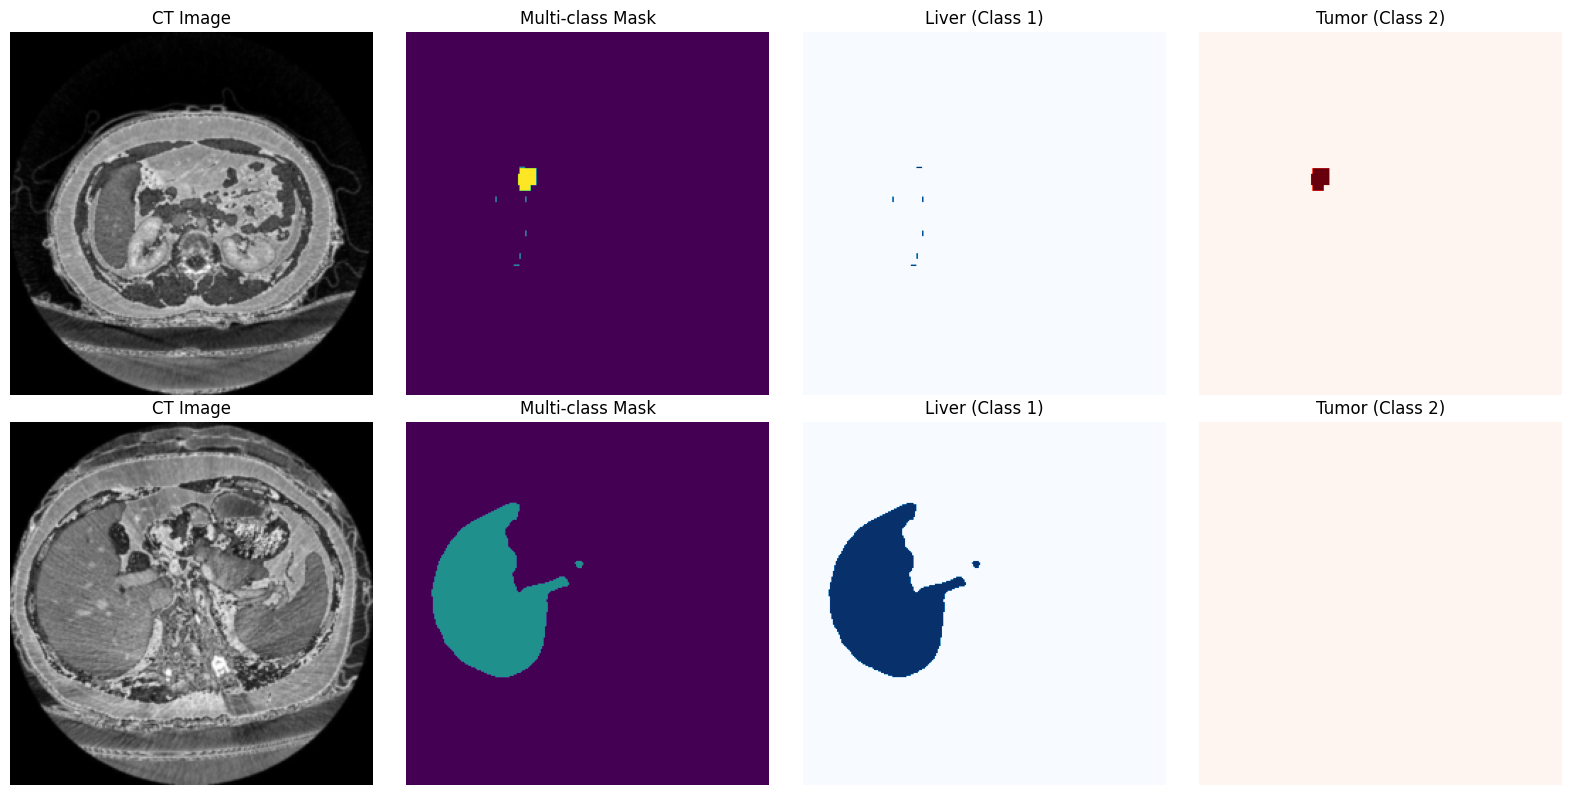

In [8]:
def prepare_segmentation_data(ct_images, liver_masks, tumor_masks):
    """
    Prepare data for multi-class segmentation
    Combine liver and tumor masks into single multi-class mask
    """
    # Add channel dimension to images
    X = ct_images[..., np.newaxis]

    # Create multi-class masks
    # 0: background, 1: liver, 2: tumor
    y = np.zeros((len(ct_images), 256, 256), dtype=np.int32)

    for i in range(len(ct_images)):
        # Set liver pixels to class 1
        y[i][liver_masks[i] > 0.5] = 1
        # Set tumor pixels to class 2 (overrides liver where tumor is present)
        y[i][tumor_masks[i] > 0.5] = 2

    return X, y

# Prepare segmentation data
print("Preparing segmentation data...")
X_seg, y_seg = prepare_segmentation_data(X_images, y_liver_masks, y_tumor_masks)

print(f"✓ Segmentation data prepared:")
print(f"  X_seg shape: {X_seg.shape}")
print(f"  y_seg shape: {y_seg.shape}")
print(f"  Unique classes in masks: {np.unique(y_seg)}")

# Calculate class distribution
class_counts = np.bincount(y_seg.flatten())
total_pixels = y_seg.size
print(f"  Class distribution:")
for i, count in enumerate(class_counts):
    print(f"    Class {i}: {count:,} pixels ({count/total_pixels:.1%})")

# Split data for training and validation
print("Splitting data into train/validation sets...")
X_train_seg, X_val_seg, y_train_seg, y_val_seg = train_test_split(
    X_seg, y_seg, test_size=0.2, random_state=42,
    stratify=classification_labels
)

# Also split classification labels for later use
y_train_class, y_val_class = train_test_split(
    classification_labels, test_size=0.2, random_state=42,
    stratify=classification_labels
)

print(f"✓ Data split completed:")
print(f"  Training set: {X_train_seg.shape[0]} samples")
print(f"  Validation set: {X_val_seg.shape[0]} samples")
print(f"  Training tumor prevalence: {np.mean(y_train_class):.1%}")
print(f"  Validation tumor prevalence: {np.mean(y_val_class):.1%}")

# Visualize multi-class masks
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    idx = np.random.randint(0, len(X_train_seg))

    # Original image
    axes[i, 0].imshow(X_train_seg[idx, :, :, 0], cmap='gray')
    axes[i, 0].set_title('CT Image')
    axes[i, 0].axis('off')

    # Multi-class mask
    axes[i, 1].imshow(y_train_seg[idx], cmap='viridis', vmin=0, vmax=2)
    axes[i, 1].set_title('Multi-class Mask')
    axes[i, 1].axis('off')

    # Individual class masks
    liver_only = (y_train_seg[idx] == 1).astype(float)
    tumor_only = (y_train_seg[idx] == 2).astype(float)

    axes[i, 2].imshow(liver_only, cmap='Blues')
    axes[i, 2].set_title('Liver (Class 1)')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(tumor_only, cmap='Reds')
    axes[i, 3].set_title('Tumor (Class 2)')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Set up callbacks for training
callbacks = [
    ModelCheckpoint(
        '/content/drive/MyDrive/best_unet_model.h5',  # Save to Google Drive
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the segmentation model
print("Starting U-Net segmentation model training...")
print("This may take some time depending on your dataset size...")

# Check GPU availability
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Training on: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

history = segmentation_model.fit(
    X_train_seg, y_train_seg,
    validation_data=(X_val_seg, y_val_seg),
    batch_size=8,  # Adjust based on Colab memory
    epochs=50,     # Adjust based on your needs
    callbacks=callbacks,
    verbose=1
)

print("✓ Segmentation model training completed!")

# Save training history
import pickle
with open('/content/drive/MyDrive/segmentation_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved to Google Drive")


Starting U-Net segmentation model training...
This may take some time depending on your dataset size...
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training on: GPU
Epoch 1/50


I0000 00:00:1751037461.134720      66 service.cc:148] XLA service 0x7c43c8001c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751037461.135524      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751037462.779476      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751037492.568278      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5819 - liver_dice: 0.2930 - loss: 0.9907 - tumor_dice: 0.0102

W0000 00:00:1751037504.942552      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1751037506.803884      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1751037508.424637      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751037508.679402      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.92895, saving model to /content/drive/MyDrive/best_unet_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 420ms/step - accuracy: 0.5860 - liver_dice: 0.2967 - loss: 0.9848 - tumor_dice: 0.0103 - val_accuracy: 0.8786 - val_liver_dice: 0.0292 - val_loss: 0.9290 - val_tumor_dice: 0.0183 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9720 - liver_dice: 0.7571 - loss: 0.2851 - tumor_dice: 0.0094
Epoch 2: val_loss improved from 0.92895 to 0.91310, saving model to /content/drive/MyDrive/best_unet_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.9720 - liver_dice: 0.7572 - loss: 0.2846 - tumor_dice: 0.0094 - val_accuracy: 0.7547 - val_liver_dice: 0.1772 - val_loss: 0.9131 - val_tumor_dice: 6.4465e-11 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9780 - liver_dice: 0.8088 - loss: 0.2031 - tumor_dice: 0.0212
Epoch 3: val_loss improved from 0.91310 to 0.88

Evaluating segmentation model...
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step
Segmentation Model Performance:
Liver:
  Dice Coefficient: 0.7601 ± 0.4043
  IoU (Jaccard):    0.7420 ± 0.3962
  Valid samples:    100

Tumor:
  Dice Coefficient: 0.8539 ± 0.2768
  IoU (Jaccard):    0.8148 ± 0.2942
  Valid samples:    100



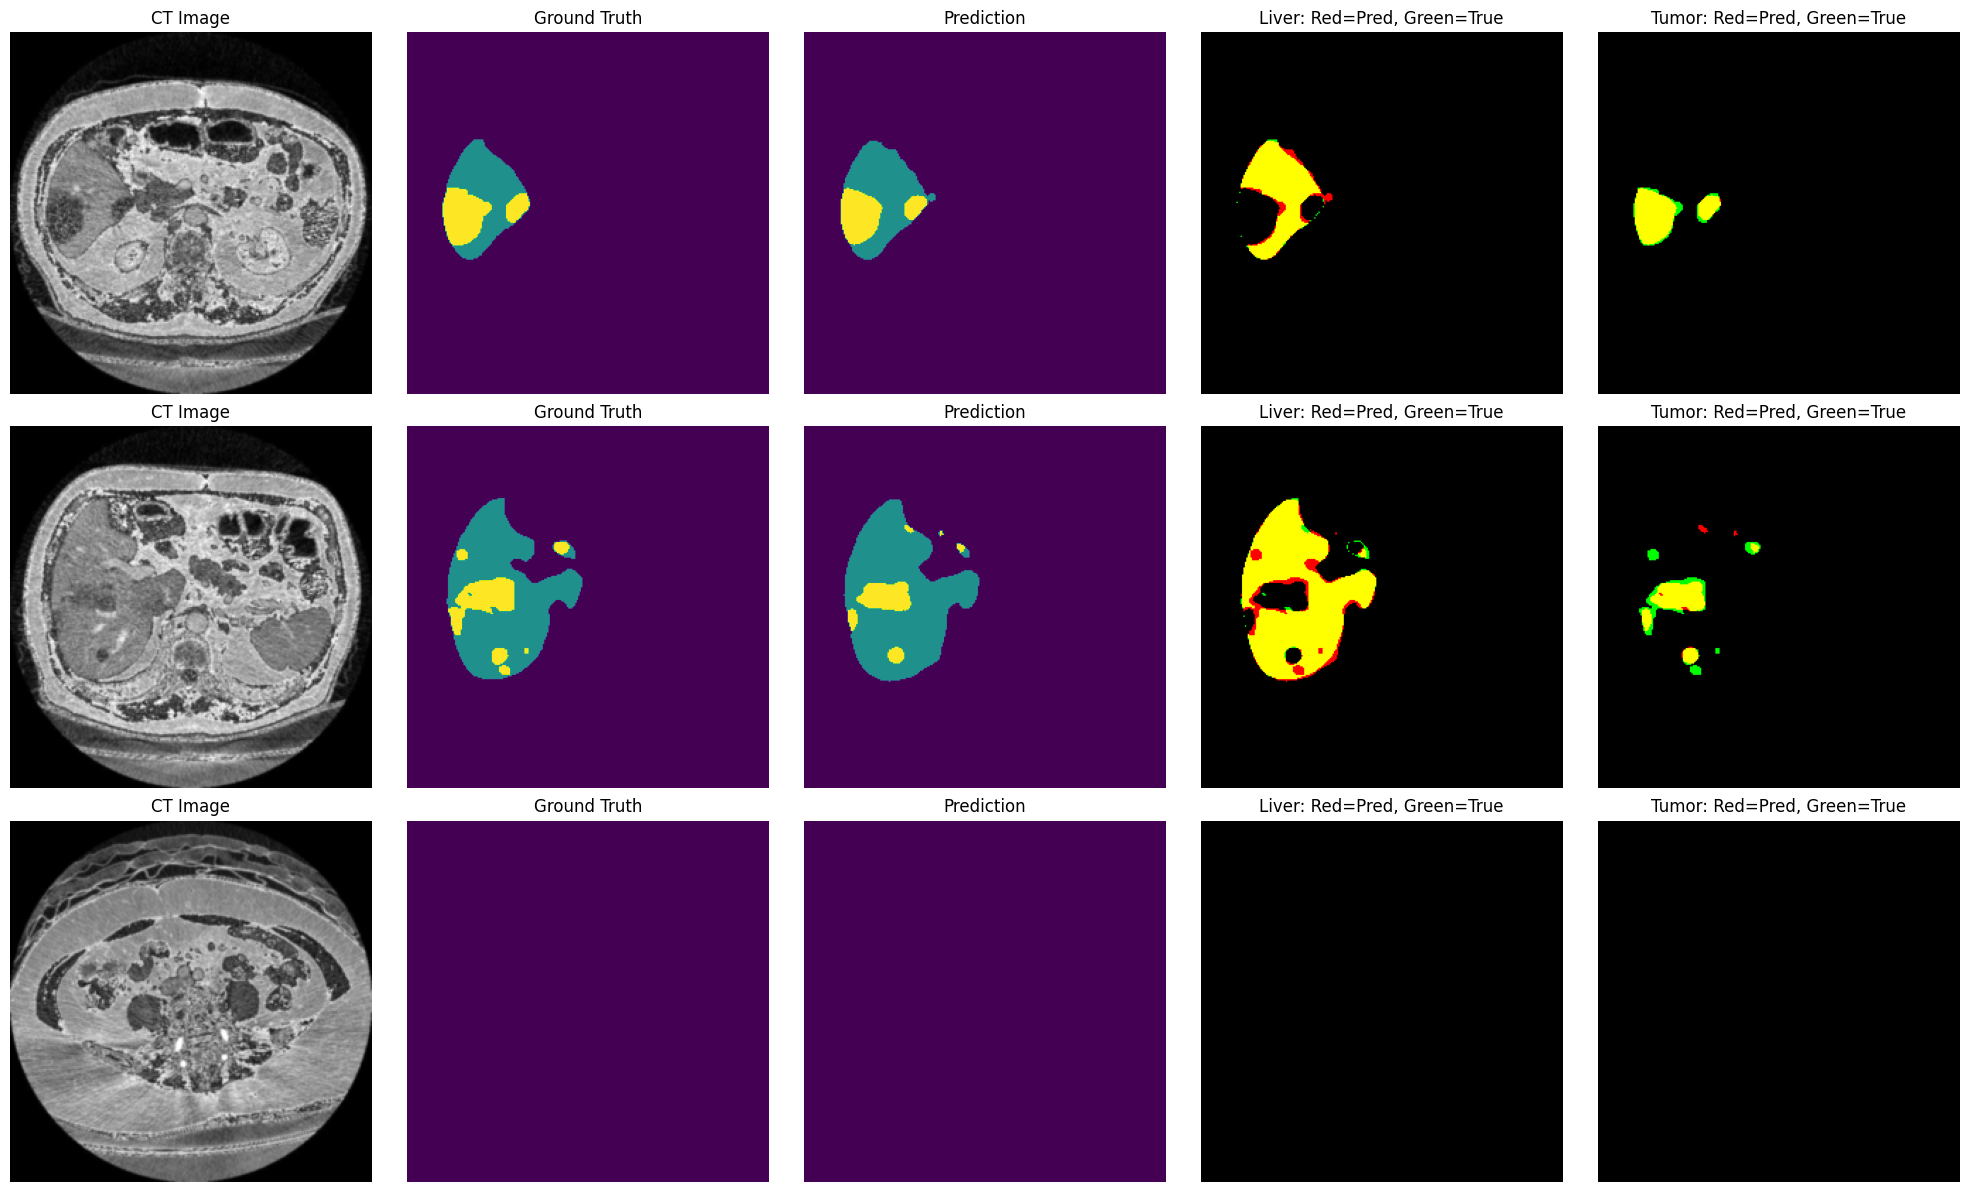

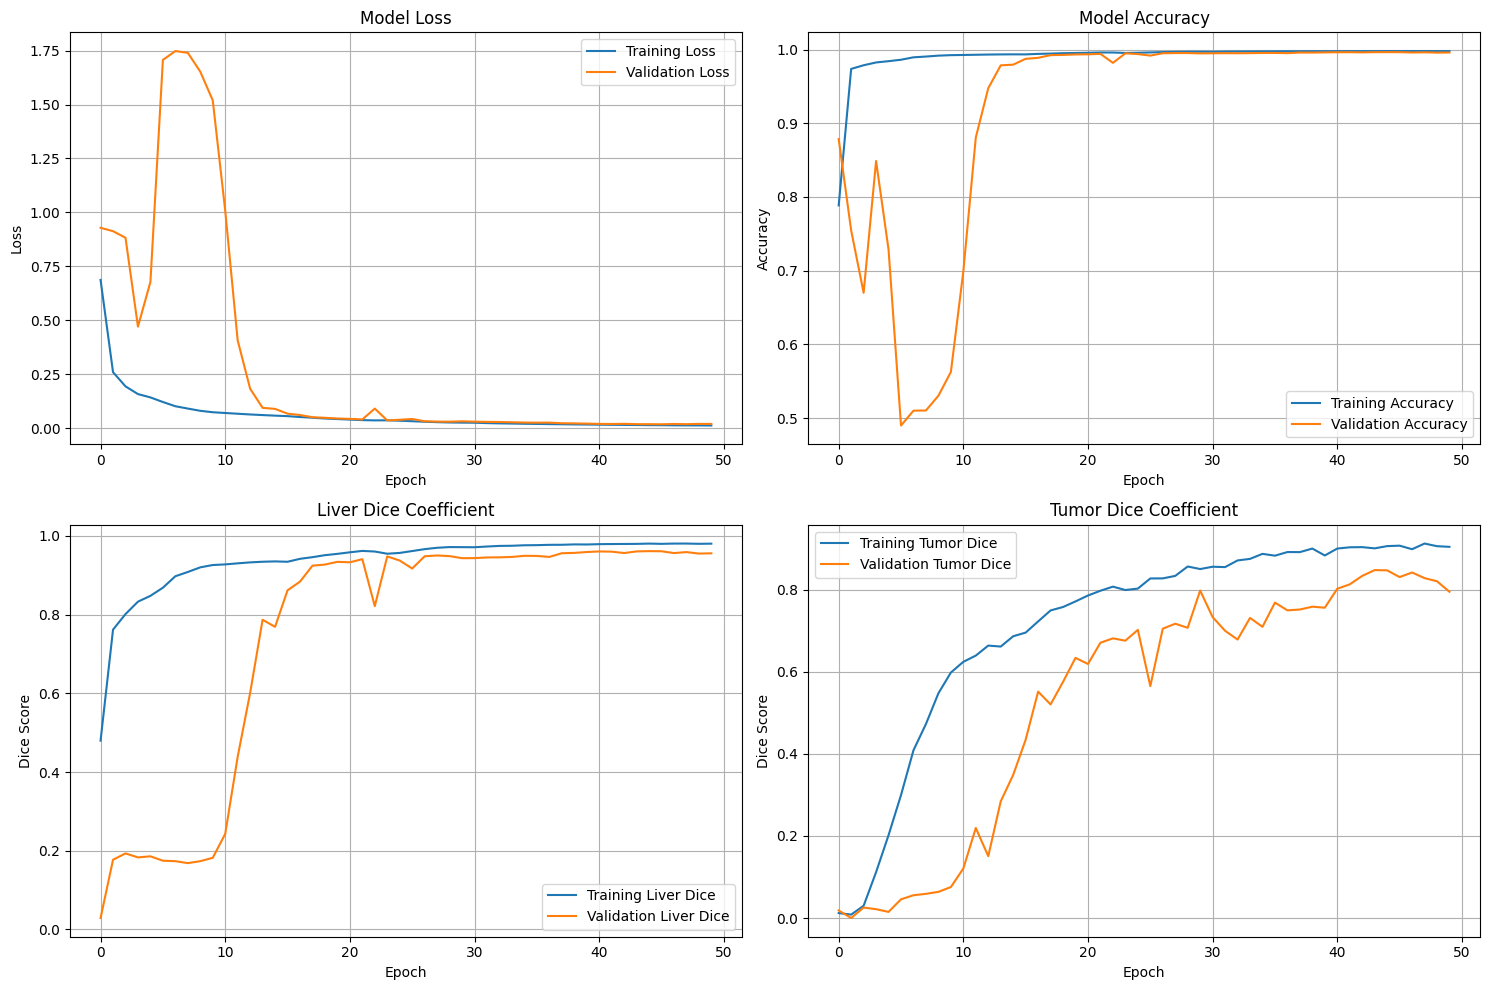

In [10]:
# Evaluation functions
def evaluate_segmentation_model(model, X_test, y_test):
    """
    Comprehensive evaluation of segmentation model
    """
    print("Evaluating segmentation model...")

    # Make predictions
    y_pred = model.predict(X_test, batch_size=8, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=-1)

    # Calculate metrics for each class
    classes = ['Background', 'Liver', 'Tumor']
    metrics_results = {}

    for class_id, class_name in enumerate(classes):
        if class_id == 0:  # Skip background
            continue

        y_true_class = (y_test == class_id).astype(int)
        y_pred_class = (y_pred_classes == class_id).astype(int)

        # Calculate Dice coefficient
        intersection = np.sum(y_true_class * y_pred_class, axis=(1, 2))
        union = np.sum(y_true_class, axis=(1, 2)) + np.sum(y_pred_class, axis=(1, 2))
        dice_scores = (2.0 * intersection + 1e-7) / (union + 1e-7)

        # Calculate IoU (Jaccard coefficient)
        intersection = np.sum(y_true_class * y_pred_class, axis=(1, 2))
        union = np.sum(y_true_class, axis=(1, 2)) + np.sum(y_pred_class, axis=(1, 2)) - intersection
        iou_scores = (intersection + 1e-7) / (union + 1e-7)

        # Handle cases where both true and predicted are empty
        valid_dice = dice_scores[~np.isnan(dice_scores)]
        valid_iou = iou_scores[~np.isnan(iou_scores)]

        metrics_results[class_name] = {
            'dice': np.mean(valid_dice) if len(valid_dice) > 0 else 0.0,
            'dice_std': np.std(valid_dice) if len(valid_dice) > 0 else 0.0,
            'iou': np.mean(valid_iou) if len(valid_iou) > 0 else 0.0,
            'iou_std': np.std(valid_iou) if len(valid_iou) > 0 else 0.0,
            'samples': len(valid_dice)
        }

    return metrics_results, y_pred_classes

# Evaluate on validation set
metrics, predictions = evaluate_segmentation_model(segmentation_model, X_val_seg, y_val_seg)

print("Segmentation Model Performance:")
print("=" * 50)
for class_name, class_metrics in metrics.items():
    print(f"{class_name}:")
    print(f"  Dice Coefficient: {class_metrics['dice']:.4f} ± {class_metrics['dice_std']:.4f}")
    print(f"  IoU (Jaccard):    {class_metrics['iou']:.4f} ± {class_metrics['iou_std']:.4f}")
    print(f"  Valid samples:    {class_metrics['samples']}")
    print()

# Visualize segmentation results
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for i in range(3):
    idx = np.random.randint(0, len(X_val_seg))

    # Original image
    axes[i, 0].imshow(X_val_seg[idx, :, :, 0], cmap='gray')
    axes[i, 0].set_title('CT Image')
    axes[i, 0].axis('off')

    # Ground truth
    axes[i, 1].imshow(y_val_seg[idx], cmap='viridis', vmin=0, vmax=2)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    # Prediction
    axes[i, 2].imshow(predictions[idx], cmap='viridis', vmin=0, vmax=2)
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

    # Liver comparison
    liver_true = (y_val_seg[idx] == 1).astype(float)
    liver_pred = (predictions[idx] == 1).astype(float)
    liver_overlay = np.stack([liver_pred, liver_true, np.zeros_like(liver_true)], axis=-1)
    axes[i, 3].imshow(liver_overlay)
    axes[i, 3].set_title('Liver: Red=Pred, Green=True')
    axes[i, 3].axis('off')

    # Tumor comparison
    tumor_true = (y_val_seg[idx] == 2).astype(float)
    tumor_pred = (predictions[idx] == 2).astype(float)
    tumor_overlay = np.stack([tumor_pred, tumor_true, np.zeros_like(tumor_true)], axis=-1)
    axes[i, 4].imshow(tumor_overlay)
    axes[i, 4].set_title('Tumor: Red=Pred, Green=True')
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

# Plot training history
if 'history' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Liver Dice
    axes[1, 0].plot(history.history['liver_dice'], label='Training Liver Dice')
    axes[1, 0].plot(history.history['val_liver_dice'], label='Validation Liver Dice')
    axes[1, 0].set_title('Liver Dice Coefficient')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Dice Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Tumor Dice
    axes[1, 1].plot(history.history['tumor_dice'], label='Training Tumor Dice')
    axes[1, 1].plot(history.history['val_tumor_dice'], label='Validation Tumor Dice')
    axes[1, 1].set_title('Tumor Dice Coefficient')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Dice Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()
